FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/df_pmax.pdf'

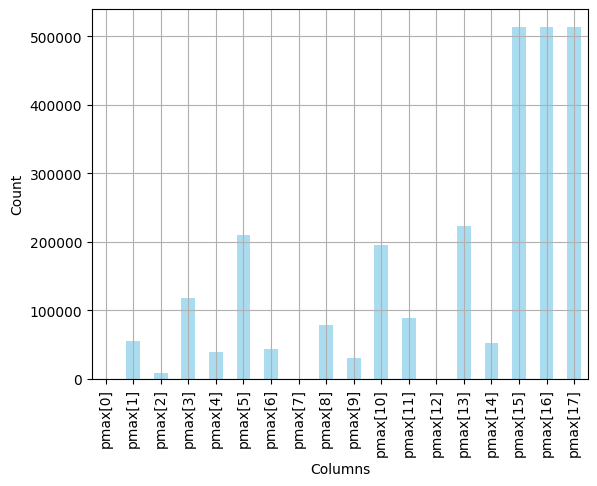

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import time


def plot_histogram(data, bins=10, title="Distribution", xlabel="Values", ylabel="Count"):
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

    plt.savefig(f"{title}.pdf", bbox_inches="tight")

    plt.show()


def plot_columns(count, title='Count'):
    count.plot(kind='bar', alpha=0.7, color='skyblue')

    plt.xlabel('Columns')
    plt.ylabel('Count')
    plt.grid()

    plt.savefig(f"{title}.pdf", bbox_inches="tight")
    plt.show()


def plot_density_grid(df, x_col, y_col, gridsize=600, cmap='viridis', mincnt=1):
    plt.hexbin(df[x_col], df[y_col], gridsize=gridsize, cmap=cmap, mincnt=mincnt)

    cbar = plt.colorbar()
    cbar.set_label('Number of Points')

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    plt.savefig("Target.pdf", bbox_inches="tight")

    plt.show()


# top 3 "pmax" values
def top_3(row):
    top_values = row.filter(like='pmax').nlargest(3)

    return pd.Series(
        [f'{int(col) + 1}_{val}_{row[f"negpmax[{col}]"]}_{row[f"rms_res[{col}]"]}' for col, val in
         zip(top_values.index.str.extract(r'pmax\[(\d+)\]', expand=False),
             top_values.values)],
        index=[f'top_{i + 1}' for i in range(3)])


if __name__ == '__main__':
    
    tempo_inizio = time.time()

    df_dev = pd.read_csv("development.csv")
    df_eval = pd.read_csv("evaluation.csv")
    df = pd.concat([df_dev, df_eval], sort=False)

    df_pmax = df.loc[:, df.columns.str.startswith('pmax')]
    count_per_column = (df_pmax > 40).sum()
    plot_columns(count_per_column, title="df_pmax")

    df_area = df.loc[:, df.columns.str.startswith('area')]
    df_rms = df.loc[:, df.columns.str.startswith('rms')]

    plot_histogram(df_pmax, title="pmax", xlabel="Magnitude(mV)")
    plot_histogram(df_area, title="area")
    plot_histogram(df_rms, title="rms")

    for i in range(15):
        df[f'rms_res[{i}]'] = df[f'rms[{i}]'] - df[f'pmax[{i}]'] - df[f'negpmax[{i}]']
    df_rms = df.copy()
    df_rms_res = df_rms.loc[:, df_rms.columns.str.startswith('rms_res')]
    conteggio_per_colonna = (df_rms_res > 0).sum()
    plot_columns(conteggio_per_colonna, title="df_rms_res")

    # List of columns
    numbers_to_search = ['7', '12', '15', '16', '17']

    # Filter of columns
    columns_to_remove = df.filter(regex='|'.join(numbers_to_search), axis=1)

    # Remove columns
    df = df.drop(columns=columns_to_remove.columns)

    # Remove column 0
    df = df.drop(df.columns[2:7], axis=1)

    train_valid_mask = ~df["x"].isna()
    plot_density_grid(df[train_valid_mask], "x", "y")

    y = df[["x", "y"]].values

    df_rms = pd.DataFrame()
    for i in range(15):
        if i not in [0, 7, 12]:
            df[f'rms_res[{i}]'] = df[f'rms[{i}]'] - df[f'pmax[{i}]'] - df[f'negpmax[{i}]']
    df_rms = df.copy()
    top_3_values_df = df_rms.apply(top_3, axis=1)

    # split values 
    top_3_values_df[['column_1', 'value_1', 'negmax_1', 'rms_res_1']] = top_3_values_df['top_1'].str.split(
        '_',
        expand=True)
    top_3_values_df[['column_2', 'value_2', 'negmax_2', 'rms_res_2']] = top_3_values_df['top_2'].str.split(
        '_',
        expand=True)
    top_3_values_df[['column_3', 'value_3', 'negmax_3', 'rms_res_3']] = top_3_values_df['top_3'].str.split(
        '_',
        expand=True)

    # Drop original columns
    top_3_values_df = top_3_values_df.drop(columns=['top_1', 'top_2', 'top_3'])

    top_3_values_df['value_1'] = top_3_values_df['value_1'].astype(float)
    top_3_values_df['value_2'] = top_3_values_df['value_2'].astype(float)
    top_3_values_df['value_3'] = top_3_values_df['value_3'].astype(float)

    # Select columns for calculate sum
    top_3_values_df['tot'] = top_3_values_df[['value_1', 'value_2', 'value_3']].sum(axis=1)

    # values normalized
    top_3_values_df['value_1_norm'] = top_3_values_df['value_1'] / top_3_values_df['tot']
    top_3_values_df['value_2_norm'] = top_3_values_df['value_2'] / top_3_values_df['tot']
    top_3_values_df['value_3_norm'] = top_3_values_df['value_3'] / top_3_values_df['tot']

    # Drop column 'tot'
    top_3_values_df = top_3_values_df.drop('tot', axis=1)

    print(top_3_values_df)



In [ ]:
    X = top_3_values_df

    feature_names = X.columns

    X_train_valid = X[train_valid_mask]
    y_train_valid = y[train_valid_mask]
    X_test = X[~train_valid_mask]

    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=42,
                                                          test_size=0.2)


    # Random Forest Regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    base_gb_regressor = GradientBoostingRegressor(n_estimators=100)
    gb_regressor = MultiOutputRegressor(base_gb_regressor)

    # Define grid parameter
    param_grid_rf = {
        'max_depth': [2, 4, 8, 16, 32],
    }

    # Define grid parameter
    param_grid_gb = {
    'estimator__max_depth': [2, 4, 8, 16, 32],
    }


    # object GridSearchCV  Random Forest
    grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, scoring='neg_mean_squared_error',
                                  cv=5)

    # object GridSearchCV per Gradient Boosting
    grid_search_gb = GridSearchCV(estimator=gb_regressor, param_grid=param_grid_gb, scoring='neg_mean_squared_error', cv=5)


    # train model
    grid_search_rf.fit(X_train, y_train)




GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [2, 4, 8, 16, 32]},
             scoring='neg_mean_squared_error')

In [ ]:
#grid_search_gb.fit(X_train, y_train)

Random Forest Best Hyperparameters: {'max_depth': 32}


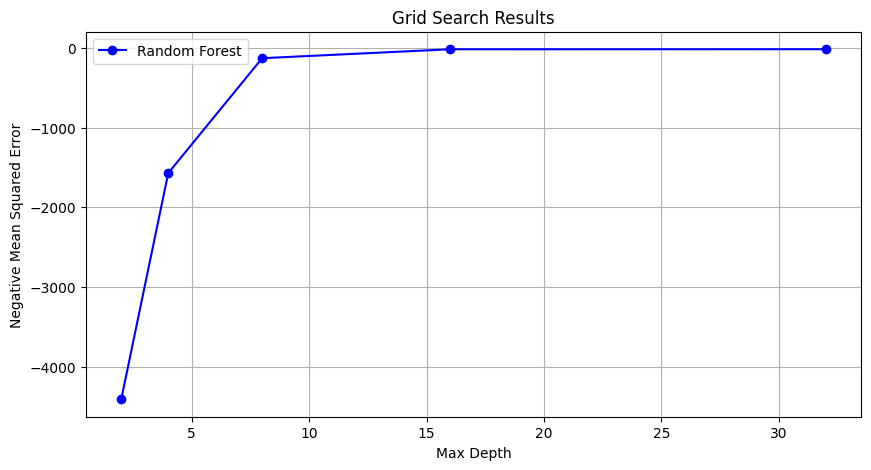

Tempo trascorso: 435.05 minuti


In [17]:
# Predict
y_pred_rf = grid_search_rf.predict(X_test)
#  y_pred_gb = grid_search_gb.predict(X_test)

# Calculate mse
mse_rf = mean_squared_error(y_valid, grid_search_rf.predict(X_valid))
#   mse_gb = mean_squared_error(y_valid, grid_search_gb.predict(X_valid))

# Calculate Euclidean distances for each event
distances_rf = np.sqrt(mse_rf)
#  distances_gb = np.sqrt(mse_gb)

# Calculate the average Euclidean distance
average_distance_rf = np.mean(distances_rf)
#  average_distance_gb = np.mean(distances_gb)

# Baseline = 6.629
# Print best
print("Random Forest Best Hyperparameters:", grid_search_rf.best_params_)
#   print("Random Forest average distance:", average_distance_rf)

# Print best Gradient Boosting
#print("\nGradient Boosting Best Hyperparameters:", grid_search_gb.best_params_)
#  print("Gradient Boosting average distance:", average_distance_gb)

# Plot 
depth_values_rf = [param['max_depth'] for param in grid_search_rf.cv_results_['params']]
scores_rf = grid_search_rf.cv_results_['mean_test_score']

#   depth_values_gb = [param['max_depth'] for param in grid_search_gb.cv_results_['params']]
#  scores_gb = grid_search_gb.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))

# Plot Random Forest
plt.plot(depth_values_rf, scores_rf, c='blue', marker='o', label='Random Forest', linestyle='-')

# Plot Gradient Boosting
#  plt.plot(depth_values_gb, scores_gb, c='red', marker='o', label='Gradient Boosting', linestyle='-')

plt.xlabel('Max Depth')
plt.ylabel('Negative Mean Squared Error')
plt.title('Grid Search Results')
plt.legend()
plt.grid()

plt.savefig("/content/drive/MyDrive/GridSearch.pdf", bbox_inches="tight")
plt.show()

# print(sorted(zip(feature_names, grid_search_rf.feature_importances_), key=lambda x: x[1], reverse=True))
'''
#PROVA

# Number of folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# cross-validation and metric to evaluate
results = cross_val_score(reg, X_train_valid, y_train_valid, cv=kfold, scoring='neg_root_mean_squared_error')

# metrics by folds
print("Accuracy per fold: ", results)

# print metrics by folds
print("Media dell'accuracy: %.2f%%" % (results.mean() * 100))

#PROVA
'''

# file csv_rf
y_pred_rf = pd.DataFrame(y_pred_rf, columns=['col1', 'col2'])
y_pred_rf = y_pred_rf.apply(lambda row: f"{row['col1']}|{row['col2']}", axis=1)
pd.DataFrame(y_pred_rf, index=df[~train_valid_mask].index).to_csv("/content/drive/MyDrive/output_rf.csv", index_label="Id",
                                                                header=["Predicted"])

# file csv_gb
#   y_pred_gb = pd.DataFrame(y_pred_gb, columns=['col1', 'col2'])
#  y_pred_gb = y_pred_gb.apply(lambda row: f"{row['col1']}|{row['col2']}", axis=1)
#  pd.DataFrame(y_pred_gb, index=df[~train_valid_mask].index).to_csv("/content/drive/MyDrive/output_gb.csv", index_label="Id",header=["Predicted"])

  # Calculate time
tempo_fine = time.time()
tempo_trascorso = tempo_fine - tempo_inizio
print(f"Tempo trascorso: {((tempo_fine - tempo_inizio) / 60):.2f} minuti")